In [238]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, scale
from sklearn.utils import resample
from skimage import transform as sktf
from skimage import exposure
from skimage.color import rgb2gray
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import linalg
from sys import getsizeof
import random
import csv
import math
import logging


session = tf.InteractiveSession()

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline
print('All modules imported.')

All modules imported.


In [248]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

testgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    rescale=1/255)  # randomly flip images

In [249]:
logging.info('hello')

INFO:root:hello


In [328]:
def applyTransformation(image):
    
    distorted = tf.image.random_brightness(image, max_delta=63)
    distorted = tf.image.random_contrast(distorted,
                                                 lower=0.2, upper=1.8)
    
    return distorted

# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, n, augment=False, testset=False, num_augment=5):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    coords = []
    num_samples_needed = 500
    
    # loop over all 43 classes
    for c in range(0, n):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        print ("Processing ", prefix)
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.__next__() # skip header
        if (not testset and not augment):
            reader = list(gtReader)
            # loop over all images in current annotations file
            num_samples_available = len(reader)
            num_augment = math.ceil(num_samples_needed/num_samples_available)
            gtFile.seek(0)
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            gtReader.__next__() # skip header

        iindex = 0
        for row in gtReader:
            
            image = plt.imread(prefix + row[0])
            if (not testset):
                label = row[7]
                labels.append(int(label)) # for one-hot encoding, conver to decimal to get correct coding.
            else:
                label = "-1"
                #labels.append(label) # the 8th column is the label
            coord = [row[3], row[4], row[5], row[6]]
            coords.append(coord)
            # crop and store the image.
            img = image[int(coord[0]):int(coord[2]),int(coord[1]):int(coord[3]),:]
            # resize to block above
            img.resize()
            # resize to 32x32x3, nearest neighbor interpolation
            #cropped = sktf.resize(img, (32,32,3), 1)
            #intense = exposure.equalize_hist(scaled)
            images.append(sktf.resize(img, (32, 32)))
            iindex += 1
            cropped = img
            
            if (augment):
                # generate a bunch of other images to augment the dataset by applying
                # affine transformations
                # reshape image for transfomration
                cropped = cropped.reshape((1,) + cropped.shape) 
                
                i = 0
                for batch, y in datagen.flow(cropped, np.array([label]), batch_size=1):
                    
                    iindex += 1
                    i += 1
                    images.append(sktf.resize(batch[0], (32, 32, 3), 3))
                    if (not testset):
                        labels.append(y[0])
                    else:
                        labels.append(sktf.resize(img, (32, 32, 3), 3))
                    
                    if (not testset):
                        if (iindex == num_samples_needed):
                            break
                        
                    if (i >= num_augment): 
                        break
                        
        print ("Processed {num_images} images".format(num_images=iindex))
        gtFile.close()
        
    return images, labels, coords

In [365]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

In [360]:
images, labels, coords = readTrafficSigns("/Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images", 1, augment=False, num_augment=1)

Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00000/
Processed 210 images


In [361]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 1
Total Images: 210


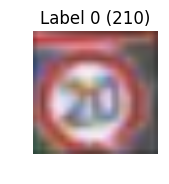

In [362]:
display_images_and_labels(images, labels)

In [333]:
imgs = np.array(images)
lbls = np.array(labels)

In [334]:
print("labels: ", lbls.shape, "\nimages: ", imgs.shape)

labels:  (39209,) 
images:  (39209, 32, 32, 3)


In [335]:
class InputDataPreProcessor(object):
    
    def __init__(self, rescale=None):
        
        self.mean = None
        self.stddev = None
        self.zca_whitening = None
        self.rescale = rescale
        
        self.train_batch_index = []
        self.validate_batch_index = []

        self.train_batch = None
        self.validate_batch = None

        self.train_batch_pointer = 0
        self.validate_batch_pointer = 0
 
 
    '''
        Generates batches of batch size from the array of images provided.
    '''
    def generate_batches(self, features, labels, batch_size=512, batch_type=None):
    
        assert batch_type is not None, 'Please provide a string for batch type, one of train, validate or test'

        fl = len(features)

        print ("Generating batches for {num_items} items, please wait...".format(num_items=fl))

        n = 0
        label_set = None
    
        for i in range(0, fl, batch_size):
            print (i, ':', batch_size*n)
            n+=1

            feature_set = features[i:batch_size*n]
            label_set = labels[i:batch_size*n]

            self.save_batch(feature_set, label_set, batch_type+"/batch_"+str(i))



        print ("{num_batches} batches generated and saved.".format(num_batches=n))
        
    '''
        Saves a single batch in the path specified.
    '''
    def save_batch(self, features, labels, path):

        if not os.path.isfile(path):

            print('Saving batch to pickle file...')

            try:
                with open(path, 'wb') as pfile:
                    pickle.dump(
                        {
                            'features': features,
                            'labels': labels,
                        },
                        pfile, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', path, ':', e)
                raise
                
                
            print ('Batch saved in pickle file {file_name}'.format(file_name=path))
    
    '''
        Get randomized datasets for training and validation

    '''
    
    def generate_training_validate_split(self, features, labels, test_split_perc=0.2):
    
        training_features, valid_features, training_labels, valid_labels = train_test_split(
            features,
            labels,
            test_size=test_split_perc,
            random_state=0)

        print('Training features and labels randomized and split.')
        
        return training_features, valid_features, training_labels, valid_labels
    
    
    '''
        Generates one-hot encoding of labels
    '''
    def generate_one_hot_encoding(self, labels):

        # Turn labels into numbers and apply One-Hot Encoding
        encoder = LabelBinarizer()
        encoder.fit(labels)
        train_labels = encoder.transform(labels)

        # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
        train_labels = train_labels.astype(np.float32)
        
        return train_labels

In [336]:
ibp = InputDataPreProcessor()

In [344]:
onehot_labels = ibp.generate_one_hot_encoding(labels)
print (onehot_labels.shape)
print (type(labels[0]), len(labels))

(39209, 43)
<class 'int'> 39209


In [319]:
def binaryToDecimal(binary):
    return

In [349]:
slbls = set(labels)
for i in sorted(slbls):
    print ("{0},{1}".format(i, onehot_labels[labels.index(i)]))



0,[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
1,[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
2,[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
3,[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
4,[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
5,[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0

In [350]:
tft, vf, tl, vl = ibp.generate_training_validate_split(images, onehot_labels)

Training features and labels randomized and split.


In [352]:
ibp.generate_batches(vf, vl, batch_size=4096, batch_type='validate0')

Generating batches for 7842 items, please wait...
0 : 0
Saving batch to pickle file...
Batch saved in pickle file validate0/batch_0
4096 : 4096
Saving batch to pickle file...
Batch saved in pickle file validate0/batch_4096
2 batches generated and saved.


In [353]:
ibp.generate_batches(tft, tl, batch_size=4096, batch_type='train0')

Generating batches for 31367 items, please wait...
0 : 0
Saving batch to pickle file...
Batch saved in pickle file train0/batch_0
4096 : 4096
Saving batch to pickle file...
Batch saved in pickle file train0/batch_4096
8192 : 8192
Saving batch to pickle file...
Batch saved in pickle file train0/batch_8192
12288 : 12288
Saving batch to pickle file...
Batch saved in pickle file train0/batch_12288
16384 : 16384
Saving batch to pickle file...
Batch saved in pickle file train0/batch_16384
20480 : 20480
Saving batch to pickle file...
Batch saved in pickle file train0/batch_20480
24576 : 24576
Saving batch to pickle file...
Batch saved in pickle file train0/batch_24576
28672 : 28672
Saving batch to pickle file...
Batch saved in pickle file train0/batch_28672
8 batches generated and saved.


In [354]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [364]:
test_images, test_labels, test_coords = readTrafficSigns("/Data/Data1/dl/udacity/traffic-signs/test/GTSRB/Final_Test/Images", 1, augment=False, testset=True, num_augment=1)

Processing  /Data/Data1/dl/udacity/traffic-signs/test/GTSRB/Final_Test/Images/00000/
Processed 12630 images


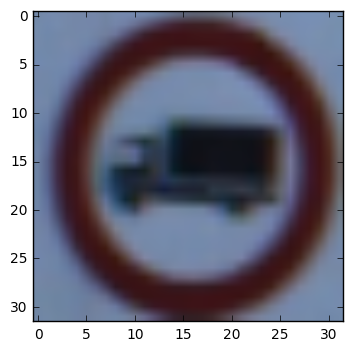

In [366]:
plt.imshow(test_images[0])

In [367]:
ibp.generate_batches(test_images, test_labels, batch_size=4096, batch_type='test0')

Generating batches for 12630 items, please wait...
0 : 0
Saving batch to pickle file...
Batch saved in pickle file test0/batch_0
4096 : 4096
Saving batch to pickle file...
Batch saved in pickle file test0/batch_4096
8192 : 8192
Saving batch to pickle file...
Batch saved in pickle file test0/batch_8192
12288 : 12288
Saving batch to pickle file...
Batch saved in pickle file test0/batch_12288
4 batches generated and saved.


In [126]:
images, labels, coords = readTrafficSigns("/Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images", 5, augment=True, testset=True, num_augment=1)

Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00000/
Processed 210 images
Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00001/
Processed 2220 images
Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00002/
Processed 2250 images
Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00003/
Processed 1410 images
Processing  /Data/Data1/dl/udacity/traffic-signs/train/GTSRB/Final_Training/Images/00004/
Processed 1980 images


In [127]:
ibp.generate_batches(images, labels, batch_size=4096, batch_type='test')

Generating batches for 8070 items, please wait...
0 : 0
Saving batch to pickle file...
Batch saved in pickle file test/batch_0
4096 : 4096
Saving batch to pickle file...
Batch saved in pickle file test/batch_4096
2 batches generated and saved.


In [132]:
labels = ibp.generate_one_hot_encoding(["0", "1", "2", "3", "4", "5", "43"])